In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from scipy.signal import dlsim, butter, lfilter, welch
import scienceplots

In [2]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

In [3]:
def new_parameters():
    inertias = np.array([7.94e-4,
                         3.79e-6,
                         3.00e-6,
                         2.00e-6,
                         7.81e-3,
                         2.00e-6,
                         (3.17e-6 - 7800*(np.pi*(0.006**4)/32)*0.342/6) + 7800*(np.pi*(0.008**4)/32)*0.342/6,
                         5.01e-5,
                         6.50e-6,
                         5.65e-5,
                         4.27e-6,
                         3.25e-4,
                         1.20e-4,
                         1.15e-5,
                         1.32e-4,
                         4.27e-6,
                         2.69e-4,
                         1.80e-4,
                         2.00e-5,
                         2.00e-4,
                         4.27e-6,
                         4.95e-2])

    stiffnesses = np.array([1.90e5,
                            6.95e3,
                            90.00,
                            90.00,
                            90.00,
                            90.00,
                            80e9*(np.pi*(0.008**4)/32)/0.342,
                            4.19e4,
                            5.40e3,
                            4.19e4,
                            1.22e3,
                            4.33e4,
                            3.10e4,
                            1.14e3,
                            3.10e4,
                            1.22e4,
                            4.43e4,
                            1.38e5,
                            2.00e4,
                            1.38e5,
                            1.22e4])

    damping = np.array([8.08,
                        0.29,
                        0.24,
                        0.24,
                        0.24,
                        0.24,
                        0.00,
                        1.78,
                        0.23,
                        1.78,
                        0.52,
                        1.84,
                        1.32,
                        0.05,
                        1.32,
                        0.52,
                        1.88,
                        5.86,
                        0.85,
                        5.86,
                        0.52])


    external_damping = np.array([0.0030,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0.0042,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0.0042,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0.2400])

    gear_ratios = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1/3, 1, 1, 1, 1, 1/4, 1, 1, 1, 1])

    return inertias, stiffnesses, damping, external_damping, gear_ratios

## Time discretized state-space model

In [4]:
def state_space_matrices(inertia, stiff, damp, damp_ext, ratios, full_B=False, gear_B=False):
    """
    Parameters:
    
    inertia : list
        The inertia values of each lumped mass in order from index 1...n
    stiff : list
        The stiffness values between each lumped mass in order from index 1...n
    damp : list
        The viscous damping values between each lumped mass in order from index 1...n
    damp_ext : list
        The external damping corresponding to torque losses from the motors and gears
    ratios : list
        The gear ratios between each lumped mass
    full_B : bool
        If true, the input matrix B is shape n x p, allowing applying an input at the
        location of every lumped mass. By default it's shape is n x 2, for applying an input
        at the locations corresponding to the driving motor and the propeller. 
        
    Returns:
    
    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    D : numpy.ndarray
        The feedthrough matrix, always a zero matrix

    """
    cn = damp*ratios
    cn2 = damp*ratios**2
    cn2 = np.hstack((cn2, 0))
    c0 = np.copy(damp)
    c0 = np.insert(c0, 0, 0, axis=0)
    cn2d = -(c0 + cn2 + damp_ext)

    A11 = (np.diag(cn2d) + np.diag(cn, k=1) + np.diag(cn, k=-1)) / inertia.reshape(inertia.shape[0], 1)

    ks = -np.hstack((stiff*ratios, 0))
    A12 = np.delete(
        (np.diag(ks) + np.diag(stiff, k=-1)) / inertia.reshape(inertia.shape[0], 1), -1, axis=1
    )


    A23 = np.delete(
        np.diag(np.hstack((ratios, 0))) + np.diag(-np.ones(len(ratios)), k=1), -1, axis=0
    )

    A = np.vstack((np.hstack((A11, A12)), np.hstack((A23, np.zeros((A23.shape[0], A23.shape[1]-1))))))

    if full_B:
        B = np.zeros(A.shape)
        for i in range(len(inertia)):
            B[i,i] += 1/inertia[i]
    elif gear_B:
        B = np.zeros((A.shape[0], 2))
        B[0,0] += 1/inertia[0]
        B[11,1] -= 1/inertia[11]
    else:
        B = np.zeros((A.shape[0], 2))
        B[0,0] += 1/inertia[0]
        B[len(inertia)-1, 1] -= 1/inertia[-1]

    C = np.zeros((3, A.shape[0]))
    C[0,6] += 1
    C[1,7] += 1
    C[2,30] += 5400
    D = np.zeros((C.shape[0], B.shape[1]))

    return A, B, C, D

In [5]:
def c2d(A, B, ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time ts.
    The function returns matrices Ad, Bd of the discrete-time system.
    """
    m, n = A.shape
    nb = B.shape[1]

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate([s, np.zeros((nb, n+nb))], axis=0)
    S = LA.expm(s*ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]

    return Ad, Bd

## Data equation matrices

In [6]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    A_power = np.copy(A)
    O = np.vstack((np.copy(C), C @ A))

    for k in range(n-2):
        A_power = A_power @ A
        O = np.vstack((O, C @ A_power))

    return O


def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    A_power = np.copy(A)
    Z = np.zeros((C @ B).shape)

    # first column
    gamma_column_first = np.vstack((
        Z,
        C @ B,
        C @ A @ B
    ))
    for _ in range(n-3):
        A_power = A_power @ A
        gamma_column_first = np.vstack((gamma_column_first, C @ A_power @ B))

    # build complete matrix, column by column, from left to right
    gamma = np.copy(gamma_column_first)
    current_column = 1
    for _ in range(1, n):
        gamma_rows = Z

        # first add zero matrices
        for _ in range(current_column):
            gamma_rows = np.vstack((gamma_rows, Z))

        # then add the impulse responses
        A_power2 = np.copy(A)

        if current_column < (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B,
                C @ A @ B # these must not be added to the last and the second to last columns
            ))

        if current_column == (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B # this has to be added to the end of the second to last column
            ))

        for _ in range(n-current_column-3):
            A_power2 = A_power2 @ A
            gamma_rows = np.vstack((gamma_rows, C @ A_power2 @ B))

        # add column on the right hand side
        gamma = np.hstack((gamma, gamma_rows))
        current_column += 1

    return gamma


def second_difference_matrix(n, m):
    D2 = np.eye(n*m) - 2*np.eye(n*m, k=2) + np.eye(n*m, k=4)

    # delete incomplete rows
    D2 = D2[:-2*m, :]

    return D2

## Step excitation data from testbench

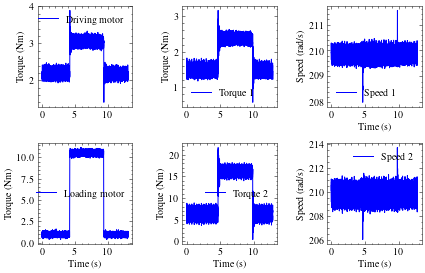

In [7]:
# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data_step = np.loadtxt("../data/masters_data/processed_data/step_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data_step = np.loadtxt("../data/masters_data/processed_data/step_sensor.csv", delimiter=",")

plt.subplot(231)
plt.plot(motor_data_step[:,0], motor_data_step[:,2], label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(234)
plt.plot(motor_data_step[:,0], motor_data_step[:,4], label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(232)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,3], label='Torque 1', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(235)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,4], label='Torque 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(233)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,1], label='Speed 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.subplot(236)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,2], label='Speed 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()

(12867, 5)
0
1
2
3


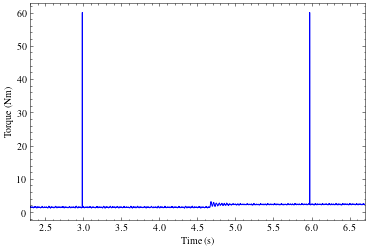

In [71]:
# add outliers to measurements
print(sensor_data_step.shape)
for i in range(int(sensor_data_step.shape[0] / 3000)):
    print(i)
    sensor_data_step[i*3000, 3] = 60
plt.plot(sensor_data_step[:,0], sensor_data_step[:,3], 'b-')
plt.xlim(2.3,6.7)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.savefig("notebook_figures/outlier_measurements.pdf")
plt.show()

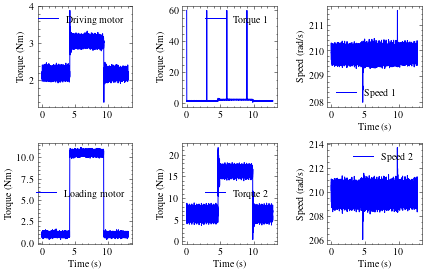

In [9]:
plt.subplot(231)
plt.plot(motor_data_step[:,0], motor_data_step[:,2], label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(234)
plt.plot(motor_data_step[:,0], motor_data_step[:,4], label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(232)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,3], label='Torque 1', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(235)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,4], label='Torque 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(233)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,1], label='Speed 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.subplot(236)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,2], label='Speed 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()

## Initiate data and state-space model

In [10]:
time = sensor_data_step[:,0]
measurements = sensor_data_step[:,1:] # measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
motors = np.vstack((motor_data_step[:,2], motor_data_step[:,4])).T # motor torque data

In [11]:
def get_testbench_state_space(dt, full_B=False, gear_B=False):
    """
    This function returns the discrete-time state-space matrices of the testbench model.
    """
    inertias, stiffs, damps, damps_ext, ratios = new_parameters()
    Ac, Bc, C, D = state_space_matrices(inertias, stiffs, damps, damps_ext, ratios, full_B=full_B, gear_B=gear_B)

    A, B = c2d(Ac, Bc, dt)

    return A, B, C, D

In [12]:
dt = np.mean(np.diff(time))
A, B, C, D = get_testbench_state_space(dt)
ss = (A, B, C, D)

In [13]:
# include second torque transducer to the observation matrix
C_mod = np.insert(C, 3, np.zeros((1, C.shape[1])), 0)
C_mod[3,22+18] += 2e4
D_mod = np.zeros((C_mod.shape[0], B.shape[1]))

In [14]:
def get_data_equation_matrices(A, B, C, D, n, bs):
    D2 = second_difference_matrix(bs, B.shape[1])
    O_mat = O(A, C, bs)
    G = gamma(A, B, C, bs)
    L = np.eye(bs*B.shape[1])

    return O_mat, G, D2, L

In [15]:
def weighted_ell2_analytical(ss, measurements, batch_size, overlap=50, lam=0.1, use_trend_filter=False):
    """
    Analytical solution of the l2 regularized LS problem.
    Minimizes the sum of squared residuals, including an l2 constraint and known covariance for input and output.
    Initial state is always assumed zero.
    """
    n = measurements.shape[0]
    bs = batch_size + 2*overlap
    loop_len = int(n/batch_size)

    A, B, C, D = ss  # state space model
    O_mat, G, D2, L = get_data_equation_matrices(A, B, C, D, n, bs)  # data equation matrices

    if use_trend_filter:
        regul_matrix = D2 # regularization matrix
    else:
        regul_matrix = L

    # measurement noise covariance matrix
    R = np.diag([0.05, 0.10, 0.20])
    #R = np.diag([0.03, 0.20, 0.01])
    R_inv = LA.inv(R)
    I = np.eye(bs)
    # measurement noise covariance assembled as a diagonal block matrix
    WR = np.kron(I, R_inv)
    LS = LA.inv(G.T @ WR @ G + lam*(regul_matrix.T@regul_matrix)) @ G.T @ WR
    
    input_estimates = []

    for i in range(loop_len):
        if i == 0:
            batch = measurements[:bs,:]
        elif i == loop_len-1:
            batch = np.zeros((bs, measurements.shape[1]))
            # zero padding to finish estimation loop correctly
        else:
            batch = measurements[i*batch_size-overlap:(i+1)*batch_size+overlap,:]

        y = batch.reshape(-1,1)

        estimate = LS @ y

        input_estimates.append(estimate)

    return input_estimates

In [16]:
def process_estimates(n_batches, overlap, estimates, nstates=43):
    """
    Here the input and initial state estimates are processed.
    Overlapped sections are discarded and the input estimate batches are stacked one after the other.
    """
    motor_estimates, propeller_estimates = [], []
    motor_est_overlap, prop_est_overlap = [], []
    for i in range(n_batches):
        if i == 0:
            all_motor_estimates = estimates[i][nstates::2]
            motor_est_overlap.append(all_motor_estimates)
            motor_estimates = all_motor_estimates[:-2*overlap]
            all_propeller_estimates = estimates[i][(nstates+1)::2]
            prop_est_overlap.append(all_propeller_estimates)
            propeller_estimates = all_propeller_estimates[:-2*overlap]
        else:
            all_motor_estimates = estimates[i][nstates::2]
            motor_est_overlap.append(all_motor_estimates)
            motor_estimates = np.concatenate(
                (motor_estimates, all_motor_estimates[overlap:-overlap])
            )
            all_propeller_estimates = estimates[i][(nstates+1)::2]
            prop_est_overlap.append(all_propeller_estimates)
            propeller_estimates = np.concatenate(
                (propeller_estimates, all_propeller_estimates[overlap:-overlap])
            )
    
    return motor_estimates, propeller_estimates

In [17]:
# HP STEP
# measurement data from the encoder 1, encoder 2 and torque transducer 1 & 2
measurements_step = sensor_data_step[:,1:]
batch_size = 500

input_estimates_step = weighted_ell2_analytical(
    ss, measurements_step[:,:-1], batch_size, overlap=100, lam=1, use_trend_filter=True
)

In [18]:
motor_input_step_est, propeller_input_step_est = process_estimates(len(input_estimates_step), 100, input_estimates_step, nstates=0)

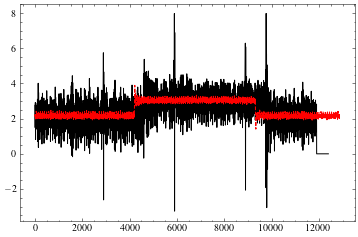

In [19]:
%matplotlib inline
plt.plot(motor_input_step_est[100:])
plt.plot(motor_data_step[:,2])
plt.show()

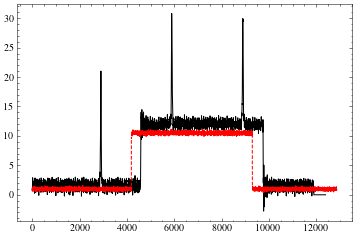

In [20]:
%matplotlib inline
plt.plot(propeller_input_step_est[100:])
plt.plot(motor_data_step[:,4])
plt.show()

## SVM input outlier filtering

In [26]:
import cvxpy as cp

def svm_reconstruction(ss, measurements, batch_size, overlap=50, lam=0.1, eps=1, use_trend_filter=False):
    """
    Analytical solution of the l2 regularized LS problem.
    Minimizes the sum of squared residuals, including an l2 constraint and known covariance for input and output.
    Initial state is always assumed zero.
    """
    n = measurements.shape[0]
    bs = batch_size + 2*overlap
    loop_len = int(n/batch_size)

    A, B, C, D = ss  # state space model
    O_mat, G, D2, L = get_data_equation_matrices(A, B, C, D, n, bs)  # data equation matrices

    if use_trend_filter:
        regul = D2 # regularization matrix
    else:
        regul = L
    
    input_estimates = []
    
    x0_naive = np.zeros((O_mat.shape[1], 1))
    speed_ratios = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1/3, 1/3, 1/3, 1/3, 1/3, 1/4, 1/4, 1/4, 1/4, 1/4]).reshape(-1,1)
    torque_ratios = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]).reshape(-1,1)

    for i in range(loop_len):
        if i == 0:
            batch = measurements[:bs,:]
        elif i == loop_len-1:
            batch = np.zeros((bs, measurements.shape[1]))
            # zero padding to finish estimation loop correctly
        else:
            batch = measurements[i*batch_size-overlap:(i+1)*batch_size+overlap,:]

        #x0_naive[:22] = np.mean(batch[:,0]) * speed_ratios
        #x0_naive[22:] = np.mean(batch[:,2])/5400 * torque_ratios
        y = batch.reshape(-1,1)
        #yhat = y - O_mat @ x0_naive

        # define optimization variables
        uhat_svm = cp.Variable((G.shape[1],1))
        xi = cp.Variable((G.shape[0], 1))
        xi_ast = cp.Variable((G.shape[0], 1))
    
        # define objective function
        objective = cp.Minimize(cp.sum_squares(regul @ uhat_svm) + lam*cp.norm1(xi + xi_ast))
    
        # define constraints
        constraints = [
            y - G @ uhat_svm <= eps + xi,
            G @ uhat_svm - y <= eps + xi_ast,
            xi >= 0,
            xi_ast >= 0
        ]
        # define and solve problem
        prob = cp.Problem(objective, constraints)
        prob.solve()
        print("prob solved ", i)

        estimate = uhat_svm.value

        input_estimates.append(estimate)

    return input_estimates

In [32]:
# create bounds
lam = 0.01
eps = 0.01

svm_step_input_est = svm_reconstruction(
    ss, measurements_step[:,:-1], batch_size, overlap=100, lam=lam, eps=eps, use_trend_filter=True
)

prob solved  0
prob solved  1
prob solved  2
prob solved  3
prob solved  4
prob solved  5
prob solved  6
prob solved  7
prob solved  8
prob solved  9
prob solved  10
prob solved  11
prob solved  12
prob solved  13
prob solved  14
prob solved  15
prob solved  16
prob solved  17
prob solved  18
prob solved  19
prob solved  20
prob solved  21
prob solved  22
prob solved  23
prob solved  24


In [33]:
motor_input_svm, propeller_input_svm = process_estimates(len(svm_step_input_est), 100, svm_step_input_est, nstates=0)

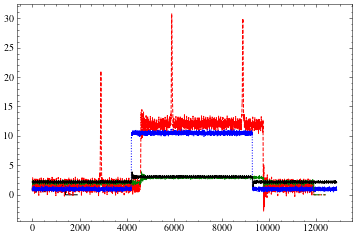

In [34]:
%matplotlib inline
plt.plot(motor_input_svm[100:])
plt.plot(motor_data_step[:,2])
plt.show()

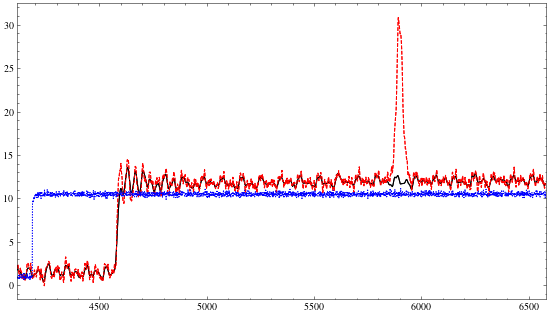

In [45]:
%matplotlib inline
plt.plot(propeller_input_svm[100:])
plt.plot(propeller_input_step_est[100:])
plt.plot(motor_data_step[:,4])
plt.show()

In [36]:
import pickle

with open('input_estimates_hp_svm.pkl', 'wb') as f:  # open a text file
    pickle.dump([motor_input_step_est, propeller_input_step_est, motor_input_svm, propeller_input_svm], f) # serialize the list
    
f.close()

In [37]:
with open('input_estimates_hp_svm.pkl', 'rb') as f:
    estimates_loaded = pickle.load(f) # deserialize using load()
motor_hp = estimates_loaded[0]
prop_hp = estimates_loaded[1]
motor_svm = estimates_loaded[2]
prop_svm = estimates_loaded[3]

(12500, 1)


In [39]:
U_est_hp = np.hstack((motor_hp, prop_hp))
U_est_svm = np.hstack((motor_svm, prop_svm))

(12500, 2)


In [43]:
time = sensor_data_step[:12500,0]
tout_hp, yout_hp, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_hp, t=time)
tout_svm, yout_svm, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_svm, t=time)

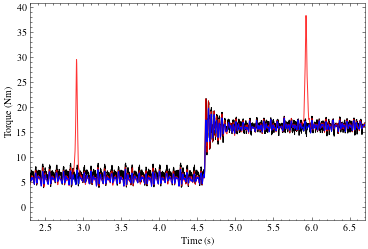

In [68]:
plt.plot(time[:-100], sensor_data_step[100:12500,4], 'k')
plt.plot(tout_hp[:-100], yout_hp[100:,-1], 'r-', alpha=0.8)
plt.plot(tout_svm[:-100], yout_svm[100:,-1], 'b-')
plt.xlim(2.3,6.7)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.savefig("notebook_figures/svm_step.pdf")
plt.show()